**Import Libraries**

In [124]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.float_format', lambda x: '%.3f' %x)
pd.set_option('display.max_columns', 500)

## 1) Data Preparation

**Task 1: Read file**

In [2]:
df_ = pd.read_csv('flo_data_20k.csv')

In [3]:
df = df_.copy()

In [4]:
df.shape

(19945, 12)

In [5]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.111,4.226,1.000,1.000,2.000,4.000,200.000
order_num_total_ever_offline,19945.000,1.914,2.063,1.000,1.000,1.000,2.000,109.000
customer_value_total_ever_offline,19945.000,253.923,301.533,10.000,99.990,179.980,319.970,18119.140
customer_value_total_ever_online,19945.000,497.322,832.602,12.990,149.980,286.460,578.440,45220.130


**Task 2: Outlier Threshold Functions**

In [7]:
def outlier_threshold(dataframe, variable):
    
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile = quartile3 - quartile1
    up_limit = quartile3 + 1.5*interquantile
    low_limit = quartile1 - 1.5*interquantile
    
    return round(low_limit), round(up_limit)


def replace_with_outlier(dataframe, variable):
    
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

**Task 3: Use threshold function for numerical variables**

In [8]:
num_cols = ['order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online']

for col in num_cols:
    replace_with_outlier(df, col)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,2.000,4.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,2.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,99.990,179.980,319.970,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,149.980,286.460,578.440,7800.000


**Task 4: Creating total_order and total_value variables**

In [10]:
df['total_order'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['total_value'] = df['customer_value_total_ever_offline'] + df['customer_value_total_ever_online']

In [11]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_order,total_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980


**Task 5: Check the variables types and convert dates to datetime object**

In [12]:
df.dtypes

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
total_order                          float64
total_value                          float64
dtype: object

In [13]:
dates = ['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline']
df[dates] = df[dates].apply(pd.to_datetime)

In [14]:
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
total_order                                 float64
total_value                                 float64
dtype: object

## 2) Creating CLTV Dataset

**Task 1: Find the last order date and create a analysis date called today_date**

In [15]:
today_date = df['last_order_date'].max() + dt.timedelta(days=2)

In [16]:
today_date = dt.datetime(today_date.year, today_date.month, today_date.day)

In [17]:
df.head(1)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_order,total_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370


**Task 2: Preparation of Lifetime Data Structure**


Recency: Last purchase - First purchase (weekly for each customer)<br>
T: Analyze date - First purchase (weekly for each customer)<br>
Frequency: Total number of repeat purchases (frequency > 1)<br>
Monetary: Average value for each purchase<br>

In [49]:
cltv_df = pd.DataFrame()

In [50]:
cltv_df['customer_id'] = df['master_id']

In [51]:
cltv_df['recency_cltv_weekly'] = (df['last_order_date']- df['first_order_date']).dt.days / 7

In [52]:
cltv_df['t_weekly'] = (df['first_order_date'].apply(lambda x: (today_date - x))).dt.days / 7

In [53]:
cltv_df['frequency'] = df['total_order']

In [54]:
cltv_df['monetary_cltv_avg'] = df['total_value'] / cltv_df['frequency']

In [55]:
cltv_df.sort_values('monetary_cltv_avg', ascending=False)

,customer_id,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,1401.800
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714,101.000,7.000,1106.467
15516,9083981a-f59e-11e9-841e-000d3a38a36f,63.571,83.857,4.000,1090.360
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2.000,862.690
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.000,94.857,2.000,859.580
...,...,...,...,...,...
19341,0dd9a790-7d63-11ea-80af-000d3a38a36f,13.857,59.143,2.000,26.735
7693,1e2dd6cc-0b1e-11eb-8ffc-000d3a38a36f,20.714,33.429,2.000,24.990
9621,1b22a066-d68b-11e9-93bc-000d3a38a36f,45.857,96.143,3.000,22.657
14980,0769f8d0-d627-11e9-93bc-000d3a38a36f,58.857,93.429,2.000,22.490


## 3) BG/NBD and Gamma-Gamma Modelling and CLTV Calculations

**Task 1: Establishment of BG/NBD Model**

In [56]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [57]:
bgf.fit(cltv_df['frequency'],
       cltv_df['recency_cltv_weekly'],
       cltv_df['t_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [58]:
cltv_df['exp_sales_3_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(12,
                                                                                           cltv_df['frequency'],
                                                                                           cltv_df['recency_cltv_weekly'],
                                                                                           cltv_df['t_weekly'])

In [59]:
cltv_df['exp_sales_6_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(24,
                                                                                      cltv_df['frequency'],
                                                                                      cltv_df['recency_cltv_weekly'],
                                                                                      cltv_df['t_weekly'])

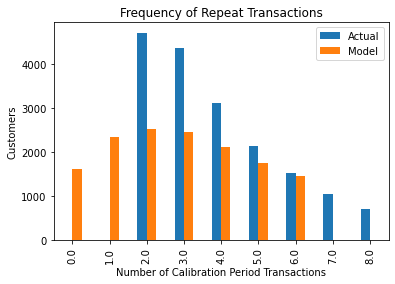

In [61]:
plot_period_transactions(bgf)
plt.show()

**Task 2: Establishment of Gamma-Gamma Model**

In [62]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [63]:
ggf.fit(cltv_df['frequency'],
       cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [64]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'], 
                                       cltv_df['monetary_cltv_avg'])

In [68]:
cltv_df.set_index('customer_id', inplace=True)

In [69]:
cltv_df.head()

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
customer_id,,,,,,,
cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.974,1.948,193.633
f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,0.983,1.966,96.665
69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.671,1.341,120.968
1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.700,1.401,67.320
d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.396,0.792,114.325


**Task 3: Calculation of CLTV Prediction for 6 months**

In [92]:
cltv = ggf.customer_lifetime_value(bgf,
                                  cltv_df['frequency'],
                                  cltv_df['recency_cltv_weekly'],
                                  cltv_df['t_weekly'],
                                  cltv_df['monetary_cltv_avg'],
                                  time=6,
                                  freq='W',
                                   discount_rate=0.01
                                  )

In [93]:
cltv = cltv.reset_index()

In [94]:
cltv_final = cltv_df.merge(cltv, on='customer_id', how='left')

In [98]:
cltv_final.sort_values('clv', ascending=False).head(20)

,customer_id,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,1401.800,1.094,2.189,1449.060,3327.777
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,11.000,758.085,1.970,3.940,767.361,3172.394
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714,101.000,7.000,1106.467,0.722,1.444,1127.612,1708.982
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.286,74.571,16.000,501.874,1.565,3.131,506.167,1662.613
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52.000,166.225,4.656,9.312,166.712,1628.887
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.429,34.429,8.000,601.226,1.265,2.531,611.493,1623.813
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2.000,862.690,0.794,1.588,923.680,1538.856
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17.000,259.865,2.781,5.561,262.073,1529.228
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571,58.714,31.000,228.530,3.084,6.168,229.607,1485.819
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.857,15.571,3.000,743.587,0.872,1.743,778.050,1423.000


## 4) Customer Segments according to CLV

In [102]:
cltv_final['segments'] = pd.qcut(cltv_final['clv'], 4, labels=['D', 'B', 'C', 'A'])

In [103]:
cltv_final.head()

,customer_id,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv,segments
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.974,1.948,193.633,395.733,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,0.983,1.966,96.665,199.431,C
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.671,1.341,120.968,170.224,C
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.700,1.401,67.320,98.946,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.396,0.792,114.325,95.012,D


In [125]:
cltv_final.groupby('segments').agg(['mean', 'max', 'min'])

recency_cltv_weekly               t_weekly               frequency  \
                        mean     max   min     mean     max   min      mean   
segments                                                                      
D                    139.000 432.571 0.000  162.183 436.286 3.571     3.769   
B                     92.630 433.000 0.000  112.818 434.714 5.143     4.405   
C                     81.988 415.571 0.000  100.327 423.571 1.143     5.093   
A                     67.427 433.429 0.000   82.550 437.143 0.714     6.647   

                      monetary_cltv_avg                 exp_sales_3_month  \
            max   min              mean      max    min              mean   
segments                                                                    
D        18.000 2.000            93.152  284.985 22.490             0.409   
B        32.000 2.000           125.789  342.840 34.316             0.525   
C        50.000 2.000           160.637  539.985 50.043             0.601   
A        57.000 2.000           228.831 1401.800 64.364             0.773   

                     exp_sales_6_month             exp_average_value           \
           max   min              mean   max   min              mean      max   
segments                                                                        
D        1.050 0.149             0.818 2.100 0.299            98.691  306.591   
B        1.568 0.162             1.051 3.137 0.324           132.251  368.390   
C        1.782 0.177             1.202 3.564 0.354           168.001  578.975   
A        4.656 0.212             1.546 9.312 0.424           238.024 1449.060   

                    clv                   
            min    mean      max     min  
segments                                  
D        25.083  80.340  112.245  12.108  
B        34.789 138.312  165.469 112.248  
C        50.597 199.533  240.058 165.469  
A        64.983 362.316 3327.777 240.085